# Library Imports & Setup

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd
from PIL import Image
from google.colab import files

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

# Mount Google Drive & Set Data Paths

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

data_loc = r'/content/drive/MyDrive/MRI'
TRAIN_ROOT = "/content/drive/MyDrive/MRI/Training"
TEST_ROOT = "/content/drive/MyDrive/MRI/Testing"

# Load Raw Dataset

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)

# Define Custom VGG16 CNN Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        return self.vgg16(x)

model = CNNModel().to(device)
model

# Prepare Transformed Datasets

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    root=TRAIN_ROOT,
    transform=transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
)

test_dataset = torchvision.datasets.ImageFolder(
    root=TEST_ROOT,
    transform=transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
)

# Create Data Loaders

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 10

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss)

# Train the Model

In [ ]:
def new_layer(layer, g):
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    newlayers = []
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m, n, 7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n, m, 7, 7))
            else:
                m, n = layer.weight.shape[1], layer.weight.shape[0]
                newlayer = nn.Conv2d(m, n, 1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n, m, 1, 1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers.append(newlayer)
        else:
            newlayers.append(layer)
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']):
        if isinstance(layer, nn.Linear):
            indices.append(i)
    return [offset + val for val in indices]

LRP Implementation for VGG16

In [ ]:
def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations

    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply variants of LRP depending on the depth
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward();
            c = activations[layer].grad
            # Assign new relevance values
            relevances[layer] = (activations[layer]*c).data
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

# %%
def predict_and_visualize(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict the class
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Apply LRP to get relevance scores
    image_relevances = apply_lrp_on_vgg16(model, image_tensor.squeeze(0))
    image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))

    # Show relevances
    pred_label = list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(predicted_class)]
    print("Predicted label for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image_relevances[:, :, 0], cmap="seismic")
    plt.title("Relevance Map")
    plt.subplot(1, 2, 2)
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Original Image")
    plt.show()


True
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


tensor(1.4610, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2673, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2336, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2572, device='cuda:0', grad_fn=

# Metrics Calculation

In [ ]:
# %% Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, classification_report

def calculate_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    class_precision = precision_score(all_labels, all_preds, average=None)

    # Get class names
    class_names = list(test_dataset.class_to_idx.keys())

    # Print results
    print("\n" + "="*50)
    print("Model Performance Metrics")
    print("="*50)
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}\n")

    print("Class-wise Precision:")
    for name, prec in zip(class_names, class_precision):
        print(f"{name}: {prec:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("="*50)

# Calculate and display metrics
calculate_metrics(model, test_loader)


Model Performance Metrics

Overall Accuracy: 0.7640
Weighted Precision: 0.8265

Class-wise Precision:
glioma_tumor: 1.0000
meningioma_tumor: 0.6667
no_tumor: 0.7836
pituitary_tumor: 0.9014

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.67      0.99      0.80       115
        no_tumor       0.78      1.00      0.88       105
 pituitary_tumor       0.90      0.86      0.88        74

        accuracy                           0.76       394
       macro avg       0.84      0.76      0.72       394
    weighted avg       0.83      0.76      0.71       394



# Predict & Visualize with LRP

Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): /content/p (793).jpg


<ipython-input-2-290b6a413d33>:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


Predicted label for this image:  pituitary_tumor


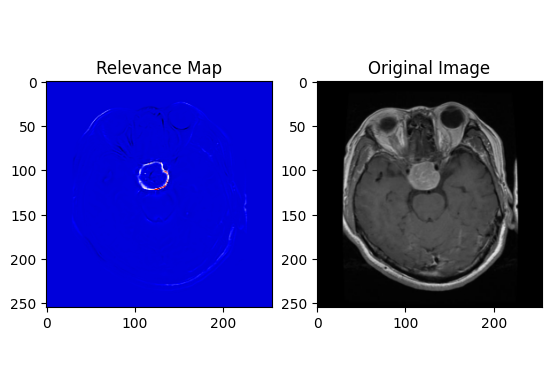

In [ ]:
from PIL import Image

# Function to predict and visualize
def predict_and_visualize(image_path):
    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    preprocess = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict the class
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Apply LRP to get relevance scores
    image_relevances = apply_lrp_on_vgg16(model, image_tensor.squeeze(0))
    image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))

    # Show relevances
    pred_label = list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(predicted_class)]
    print("Predicted label for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image_relevances[:, :, 0], cmap="seismic")
    plt.title("Relevance Map")
    plt.subplot(1, 2, 2)
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Original Image")
    plt.show()

# Input function to get the image path
def upload_image():
    # Ask the user for the image path
    image_path = input("Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): ")
    return image_path

# Main execution
if __name__ == "__main__":
    image_path = upload_image()
    predict_and_visualize(image_path)

Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): /content/m (6).jpg


<ipython-input-2-290b6a413d33>:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


Predicted label for this image:  meningioma_tumor


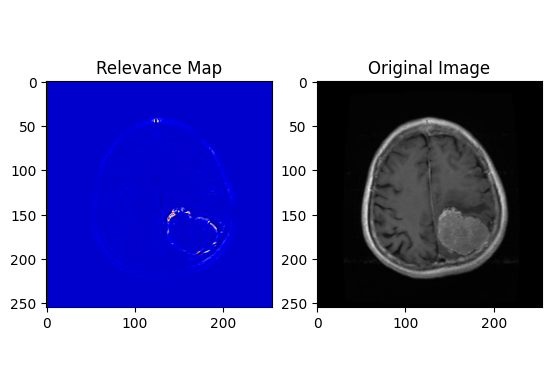

In [ ]:
from PIL import Image

# Function to predict and visualize
def predict_and_visualize(image_path):
    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    preprocess = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict the class
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Apply LRP to get relevance scores
    image_relevances = apply_lrp_on_vgg16(model, image_tensor.squeeze(0))
    image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))

    # Show relevances
    pred_label = list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(predicted_class)]
    print("Predicted label for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image_relevances[:, :, 0], cmap="seismic")
    plt.title("Relevance Map")
    plt.subplot(1, 2, 2)
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Original Image")
    plt.show()

# Input function to get the image path
def upload_image():
    # Ask the user for the image path
    image_path = input("Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): ")
    return image_path

# Main execution
if __name__ == "__main__":
    image_path = upload_image()
    predict_and_visualize(image_path)

Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): /content/4.jpg


<ipython-input-2-290b6a413d33>:179: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


Predicted label for this image:  no_tumor


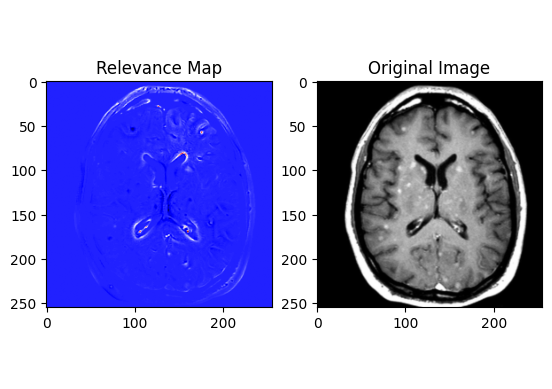

In [ ]:
from PIL import Image

# Function to predict and visualize
def predict_and_visualize(image_path):
    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    preprocess = transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor()
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict the class
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    # Apply LRP to get relevance scores
    image_relevances = apply_lrp_on_vgg16(model, image_tensor.squeeze(0))
    image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))

    # Show relevances
    pred_label = list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(predicted_class)]
    print("Predicted label for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image_relevances[:, :, 0], cmap="seismic")
    plt.title("Relevance Map")
    plt.subplot(1, 2, 2)
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Original Image")
    plt.show()

# Input function to get the image path
def upload_image():
    # Ask the user for the image path
    image_path = input("Enter the path to the image file (e.g., /content/drive/MyDrive/MRI/image.jpg): ")
    return image_path

# Main execution
if __name__ == "__main__":
    image_path = upload_image()
    predict_and_visualize(image_path)